## Download Dataset from Kaggle

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
!kaggle datasets download -d snap/amazon-fine-food-reviews
## unzip the downloaded dataset
!unzip "/content/amazon-fine-food-reviews.zip" -d "Dataset"

kaggle.json


## Attention layer not available in keras so we have to implement that our own or can use third party 

## for this problem we take attention layer code from [here](https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py)

In [ ]:
from attention import AttentionLayer

In [ ]:
## importing necesary librries
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
# pd.set_option('display.max_colwidth', 200)
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')

In [ ]:
review_dataset = pd.read_csv('/content/Dataset/Reviews.csv')
print(f"Dataset Shape :- {review_dataset.shape}")

In [ ]:
review_dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
## drop duplicates and NaN values 
review_dataset.drop_duplicates(subset=['Text'],  inplace=True)
review_dataset.dropna(axis=0, inplace=True)

In [ ]:
review_dataset.shape

(393565, 10)

In [ ]:
## dataset info
review_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393565 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      393565 non-null  int64 
 1   ProductId               393565 non-null  object
 2   UserId                  393565 non-null  object
 3   ProfileName             393565 non-null  object
 4   HelpfulnessNumerator    393565 non-null  int64 
 5   HelpfulnessDenominator  393565 non-null  int64 
 6   Score                   393565 non-null  int64 
 7   Time                    393565 non-null  int64 
 8   Summary                 393565 non-null  object
 9   Text                    393565 non-null  object
dtypes: int64(5), object(5)
memory usage: 33.0+ MB


## PReprocessing
### Steps 
##### Lower case
##### remove HTML tags
##### Contraction mapping
##### remove single characters
##### remove text inside the ()
##### remove punctuations and special characters
##### remvoe stopwords
##### remvoe short words

In [ ]:
## contraction map
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def text_cleaner(text, num):
  newstring = text.lower()
  newstring = BeautifulSoup(newstring, 'lxml').text
  newstring = re.sub(r'\([^)]*\)', '', newstring)
  newstring = re.sub('"','', newstring)
  newstring = ' '.join([CONTRACTION_MAP[t] if t in CONTRACTION_MAP else t for t in newstring.split(" ")]) 
  newstring = re.sub(r"'s\b","",newstring)
  newstring = re.sub("[^a-zA-Z]", " ", newstring) 
  newstring = re.sub('[m]{2,}', 'mm', newstring)
  if num==0:
    tokens = [w for w in newstring.split() if not w in stop_words]
  else:
    tokens=newstring.split()
  long_words=[]
  for i in tokens:
    if len(i)>1:
      long_words.append(i)   
  return (" ".join(long_words)).strip()

In [ ]:
## call the preprocessing function (text_cleaner)
preprocessed_text = []
for each_text in review_dataset['Text']:
  preprocessed_text.append(text_cleaner(each_text, 0))

In [ ]:
preprocessed_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [ ]:
## call the text cleaner function for summary preprocessing
%%time
preprocessed_summary = []
for each_sum in review_dataset['Summary']:
  preprocessed_summary.append(text_cleaner(each_sum,1))

CPU times: user 1min 8s, sys: 3 s, total: 1min 11s
Wall time: 1min 11s


In [ ]:
preprocessed_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [ ]:
## append to review dataset
review_dataset['clean_text'] = preprocessed_text
review_dataset['clean_summary'] = preprocessed_summary

In [ ]:
review_dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,clean_text,clean_summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,good quality dog food
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...,not as advertised
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...,delight says it all
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,cough medicine
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,great taffy


In [ ]:
## drop empty rows
review_dataset.replace('',np.nan, inplace=True)
review_dataset.dropna(axis=0, inplace=True)

In [ ]:
review_dataset.shape

(393213, 12)

## EDA (Exploratory Data Analysis)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
text_len = []
summary_len = []

for text in review_dataset['clean_text']:
  text_len.append(len(text.split()))

for summary in review_dataset['clean_summary']:
  summary_len.append(len(summary.split()))

In [ ]:
length_df = pd.DataFrame({'Text':text_len, 'Summary':summary_len})

In [ ]:
max(summary_len), max(text_len)

(28, 1919)

In [ ]:
length_df.head()

,Text,Summary
0,23,4
1,18,3
2,39,4
3,17,2
4,13,2


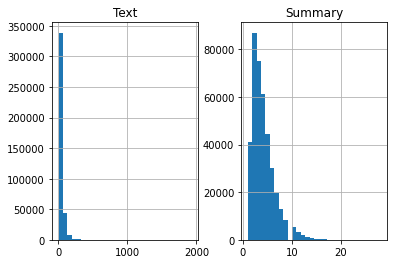

In [ ]:
length_df.hist(bins=30)
plt.show()

In [ ]:
## fix summary and text to some number and take only that length of summery and text 
max_text_len = 60
max_summary_len = 10

cleaned_text = np.array(review_dataset['clean_text'])
cleaned_summary = np.array(review_dataset['clean_summary'])

short_text = []
short_summary = []

for index in range(len(cleaned_text)):
  summary_len = len(cleaned_summary[index].split())
  text_len = len(cleaned_text[index].split())
  if (summary_len <= max_summary_len) and (text_len<=max_text_len):
    short_text.append(cleaned_text[index])
    short_summary.append(cleaned_summary[index])

df = pd.DataFrame({'short_text':short_text, 'short_summary':short_summary})

In [ ]:
df.head()

,short_text,short_summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [ ]:
df.shape

(326947, 2)

In [ ]:
## adding start and end tokens to summary
df['short_summary'] = df['short_summary'].apply(lambda x:'starttoken '+ x +' endtoken')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
## splitting whole dataset into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(np.array(df['short_text']), np.array(df['short_summary']), test_size=0.1, random_state=42, shuffle=False)

In [ ]:
len(X_train), len(X_test)

(294252, 32695)

## Tokenization


In [ ]:
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))

## checking about rare words and its coverage
thresh_hold = 4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in X_tokenizer.word_counts.items():
  tot_cnt=tot_cnt+1
  tot_freq=tot_freq+value
  if(value<thresh_hold):
    cnt=cnt+1
    freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

## preparing tokenization on train data
X_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
X_tokenizer.fit_on_texts(list(X_train))

## convert text to sequences of integers 
X_train_seq = X_tokenizer.texts_to_sequences(X_train)
X_test_seq = X_tokenizer.texts_to_sequences(X_test)

## padding zero upto max length 
X_train = pad_sequences(X_train_seq, maxlen=max_text_len, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=max_text_len, padding='post')

## vocabulary size 
text_vocab_size = X_tokenizer.num_words + 1

print(f"text vocabulary size {text_vocab_size}")

% of rare words in vocabulary: 67.79917635658916
Total Coverage of rare words: 0.9671934150140546
text vocabulary size 26586


### Summary tokenizer

In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


## preparing summary tokenizer for training data summary
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_train))

## sequence 
y_train_seq = y_tokenizer.texts_to_sequences(y_train)
y_test_seq = y_tokenizer.texts_to_sequences(y_test)

## padding 
y_train = pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test = pad_sequences(y_test_seq , maxlen=max_summary_len, padding='post')

## vocabulary size 
summary_vocab_size = y_tokenizer.num_words + 1

print(f"Summary vocabulary size {summary_vocab_size}")

% of rare words in vocabulary: 74.89801265017402
Total Coverage of rare words: 2.008896445976104
Summary vocabulary size 6708


In [ ]:
y_tokenizer.word_counts['starttoken'],len(y_train)

(294252, 294252)

In [ ]:
## deleting rows which are having only start & end toekns 
ind=[]
for index in range(len(y_train)):
  cnt=0
  for j in y_train[index]:
    if j!=0:
      cnt=cnt+1
  if cnt==2:
    ind.append(index)

y_train=np.delete(y_train,ind, axis=0)
X_train=np.delete(X_train,ind, axis=0)

In [ ]:
len(X_train)

291073

In [ ]:
ind=[]
for index in range(len(y_test)):
  cnt=0
  for j in y_test[index]:
    if j!=0:
      cnt=cnt+1
  if cnt==2:
    ind.append(index)

y_test=np.delete(y_test,ind, axis=0)
X_test=np.delete(X_test,ind, axis=0)

In [ ]:
len(X_test)

32333

## building model

In [ ]:
from keras import backend as k
k.clear_session() 

In [ ]:
latent_dim = 300
embedding_dim = 300

In [ ]:
# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(text_vocab_size, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(summary_vocab_size, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(summary_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 300)      7975800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 300), (N 721200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 300)      7975800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 300), (N 721200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
history=model.fit(
    [X_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/50
2275/2275 [==============================] - 1566s 684ms/step - loss: 2.5367 - val_loss: 2.0581
Epoch 2/50
2275/2275 [==============================] - 1517s 667ms/step - loss: 2.0194 - val_loss: 1.9562
Epoch 3/50
2275/2275 [==============================] - 1493s 656ms/step - loss: 1.9276 - val_loss: 1.8988
Epoch 4/50
2275/2275 [==============================] - 1484s 652ms/step - loss: 1.8820 - val_loss: 1.8724
Epoch 5/50
2275/2275 [==============================] - 1505s 662ms/step - loss: 1.8504 - val_loss: 1.8595
Epoch 6/50
2275/2275 [==============================] - 1506s 662ms/step - loss: 1.8314 - val_loss: 1.8563
Epoch 7/50
2275/2275 [==============================] - 1510s 664ms/step - loss: 1.8227 - val_loss: 1.8510
Epoch 8/50
2275/2275 [==============================] - 1488s 654ms/step - loss: 1.8068 - val_loss: 1.8510
Epoch 9/50
2275/2275 [==============================] - 1471s 646ms/step - loss: 1.7904 - val_loss: 1.8533
Epoch 10/50
2275/2275 [==============

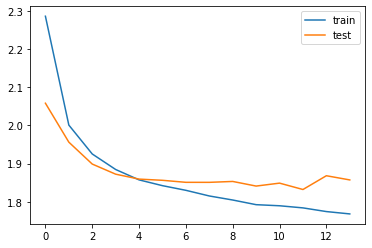

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = X_tokenizer.index_word
target_word_index = y_tokenizer.word_index

### Model Inference

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['starttoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='endtoken'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'endtoken'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['starttoken']) and i!=target_word_index['endtoken']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(X_train[i]))
    print("Original summary:",seq2summary(y_train[i]))
    print("Predicted summary:",decode_sequence(X_train[i].reshape(1,max_text_len)))
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better 
Original summary: good quality dog food 
Predicted summary:  good food


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo 
Original summary: not as advertised 
Predicted summary:  not as advertised


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat edmund selling brother sisters witch 
Original summary: delight says it all 
Predicted summary:  sweet treat


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal 
Original summary: cough medicine 
Predicted